In [2]:
import re
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pprint import pprint
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})


hatches = ['o', '*', '\\\\', 'O', 'x', '\\', '--', 'o']
markers = ['o', '*', "^"]
linestyles = ['dashdot', 'solid', '--']
orig_colors = sns.color_palette("colorblind")
colors = [
    orig_colors[2],
    orig_colors[4],
    orig_colors[0],
    orig_colors[1],
    orig_colors[3],
    orig_colors[5],
    orig_colors[7],
    orig_colors[8],
    orig_colors[9],
]
FWD_TIME_COLOR = orig_colors[7]
BWD_TIME_COLOR = orig_colors[8]
STEP_TIME_COLOR = orig_colors[9]
GPU_PER_NODE = 4
num_steps = 10
models = [
            {'n': 1, 'm': 3, 'H': 2560, 'F': 11008, 'N': 30, 'L': 32, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 45}, 
            {'n': 2, 'm': 7, 'H': 4096, 'F': 11008, 'N': 32, 'L': 32, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 83}, 
            {'n': 2, 'm': 8.3, 'H': 3072, 'F': 11008, 'N': 72, 'L': 32, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 83}, 
            {'n': 2, 'm': 10, 'H': 4096, 'F': 12400, 'N': 50, 'L': 32, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 83}, 
            {'n': 4, 'm': 13, 'H': 5120, 'F': 13824, 'N': 40, 'L': 40, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 166}, 
            {'n': 4, 'm': 20, 'H': 5120, 'F': 16384, 'N': 40, 'L': 64, 'U': 2048, 'S': 16, 'K': 10, 'mbs': 1, 'ckpt_size': -1}, 
            {'n': 8, 'm': 30, 'H': 6656, 'F': 17920, 'N': 60, 'L': 52, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 444}, 
            {'n': 20, 'm': 70, 'H': 8192, 'F': 28672, 'N': 80, 'L': 64, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 1065},
            {'n': 70, 'm': 175, 'H': 14336, 'F': 28672, 'N': 70, 'L': 112, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 8, 'ckpt_size': 2754},
]
DEFAULT_DEEPSPEED = "DeepSpeed ZeRO-3"
PARTLY_OPTIMIZED = "Deep Optimizer States (only backpass)"
FULLY_OPTIMIZED = "Deep Optimizer States"

approach_code = {
    DEFAULT_DEEPSPEED: 0,
    PARTLY_OPTIMIZED: 1,
    FULLY_OPTIMIZED: 2
}
base_config = {"basepath":"./", "approach": DEFAULT_DEEPSPEED, "dp": 1, "tp": 1, "ga": 1, "tf_ratio":1, 
                "act_ckpt":True, "mbs": 4, "gbs": 4, "subg": int(100*1e6), "opt_gaps": 5, "num_steps": 10}
df_columns = [
    'elapsed_time_per_iteration_ms', 
    'iter_time',
    'step_start',
    'step_end',
    'samples_per_second', 
    'TFLOPs', 
    'fwd', 
    'bwd', 
    'step',
    'bwd_inner_microstep', 
    'bwd_allreduce_microstep', 
    'step_microstep'
]

def get_filename(m, c):
    is_prefetch = 1 if c['approach'] == FULLY_OPTIMIZED else 0
    is_async = 1 if c['approach'] in (PARTLY_OPTIMIZED, FULLY_OPTIMIZED)  else 0
    return (
            f"{c['basepath']}/log-{m['m']}B-tp{c['tp']}-dp{c['dp']}-l{m['N']}-h{m['H']}-a{m['L']}-sl{m['U']}-"
            f"gbs{c['gbs']}-mbs{c['mbs']}-ratio{c['tf_ratio']}-subg{c['subg']}-prefetch{is_prefetch}-"
            f"flush_async{is_async}-opt_gaps{c['opt_gaps']}.log"
    )

def parse_log(m, c):
    
    log_file = get_filename(m, c)
    print(f"Reading {log_file}")       
    data = {k: [] for k in df_columns}
    with open(log_file, 'r') as file:
        for line in file:
            match = re.findall(r'<<<TIMER:step_start,(\d+)>>>', line)
            for x in match:
                data['step_start'].append(int(x))
            
            match = re.findall(r'<<<TIMER:step_end,(\d+)>>>', line)
            for x in match:
                data['step_end'].append(int(x))
            
            match = re.findall(r'<TIMER:interval-time,(\d+\.\d+)>', line)
            for x in match:
                data['iter_time'].append(float(x))
            
            match = re.search(r'elapsed time per iteration \(ms\): (\d+\.\d+)', line)
            if match:
                data['elapsed_time_per_iteration_ms'].append(float(match.group(1)))

            match = re.search(r'samples per second: (\d+\.\d+)', line)
            if match:
                data['samples_per_second'].append(float(match.group(1)))

            match = re.search(r'TFLOPs: (\d+\.\d+)', line)
            if match:
                data['TFLOPs'].append(float(match.group(1)))

            match = re.search(r'fwd: (\d+\.\d+)', line)
            if match:
                data['fwd'].append(float(match.group(1)))

            match = re.search(r'bwd: (\d+\.\d+)', line)
            if match:
                data['bwd'].append(float(match.group(1)))
            
            match = re.search(r'\|\s*step: (\d+\.\d+)', line)
            if match:
                data['step'].append(float(match.group(1)))

            match = re.search(r'bwd_inner_microstep: (\d+\.\d+)', line)
            if match:
                data['bwd_inner_microstep'].append(float(match.group(1)))

            match = re.search(r'bwd_allreduce_microstep: (\d+\.\d+)', line)
            if match:
                data['bwd_allreduce_microstep'].append(float(match.group(1)))

            match = re.search(r'step_microstep: (\d+\.\d+)', line)
            if match:
                data['step_microstep'].append(float(match.group(1)))

    if c['dp']*c['tp'] > 1: # This is used only because every rank is printing `interval-time`
        k = c['dp']*c['tp']
        num_entries = len(data['iter_time']) // k
        iter_times = [sum(data['iter_time'][i*k:(i+1)*k]) / k for i in range(num_entries)]
        
        step_starts = [min(data['step_start'][i*k:(i+1)*k]) for i in range(num_entries)]
        step_ends = [max(data['step_end'][i*k:(i+1)*k]) for i in range(num_entries)]
        data['iter_time'] = iter_times
        data['step_start'] = step_starts
        data['step_end'] = step_ends
    if len(data['step']) == 0:  # This means that we couldn't complete even one step due to OOM
        data = {k: None for k in df_columns}
    df = pd.DataFrame(data, columns=df_columns)
    
    # We would have 10 values, select the last 5 of them
    df = df.tail(len(df.index)-1)
    return df

def get_avg(arr):
    return sum(arr)/len(arr)


Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1.0-subg100000000-prefetch0-flush_async0-opt_gaps0.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1.0-subg100000000-prefetch1-flush_async1-opt_gaps2.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.9-subg100000000-prefetch0-flush_async0-opt_gaps0.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.9-subg100000000-prefetch1-flush_async1-opt_gaps2.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.8-subg100000000-prefetch0-flush_async0-opt_gaps0.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.8-subg100000000-prefetch1-flush_async1-opt_gaps2.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.7-subg100000000-p

/tmp/ipykernel_52876/690925755.py:80: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


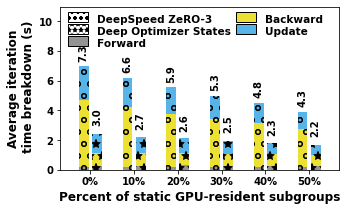

In [27]:
###############################################################
# Plot for iteration breakdown of different twinflow ratios
###############################################################
def plot_diff_twinflow_iter_time(m, config, data):
    output_file = f"./plots/diff-twinflow-iter-time"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.3
    bar_gap = -0.075
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))

    offset = -0.5
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
    
    # Add the legend for hatches first
    for i, blabel in enumerate(bar_labels):
        label = DEFAULT_DEEPSPEED
        if blabel == 2:
            label = FULLY_OPTIMIZED
        ax.bar(xrange, np.zeros(len(xrange)), label=label, hatch=hatches[i], color='white')
    
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        iter_time[blabel] = [get_avg(data[glabel][blabel]['iter_time']) for glabel in group_labels]
        fwd_time[blabel] = [get_avg(data[glabel][blabel]['fwd'])/1e3 for glabel in group_labels]
        bwd_time[blabel] = [get_avg(data[glabel][blabel]['bwd'])/1e3 for glabel in group_labels]
        step_time[blabel] = [get_avg(data[glabel][blabel]['step'])/1e3 for glabel in group_labels]
        
        bottom = np.zeros(len(fwd_time[blabel]))
        ax.bar(xrange + offset * bar_width, fwd_time[blabel], bar_width+bar_gap, 
               label=f'Forward', bottom=bottom, color=FWD_TIME_COLOR, hatch=hatches[i])
        bottom += fwd_time[blabel]
        ax.bar(xrange + offset * bar_width, bwd_time[blabel], bar_width+bar_gap, 
               label=f'Backward', bottom=bottom, color=BWD_TIME_COLOR, hatch=hatches[i])
        bottom += bwd_time[blabel]
        ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, 
               label=f'Update', bottom=bottom, color=STEP_TIME_COLOR, hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        offset = -0.5
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            max_y = max(max_y, value)
            ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 0.0), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_ylabel('Average iteration\n time breakdown (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xlabel('Percent of static GPU-resident subgroups', fontsize=12, fontweight='bold')
    ax.set_xticklabels([f"{int(100-100*x)}%" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.5)
    # Plot the TFLOPs on secondary y-axis
#     tflops = {}
#     ax2 = ax.twinx()
#     for i, blabel in enumerate(bar_labels):
#         tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
#         ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
#                  markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
#     ax2.tick_params(axis='y', color='blue', labelcolor='blue')
#     ax2.spines['right'].set_color('blue')
#     ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
#     ax2.set_ylim(bottom=-20, top=130)

    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3]
    legends = ax.legend(handles, labels, 
                        ncol=2, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
m = list(filter(lambda x: x.get('m') == 20, models))[0]
for tfr in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]:
    config = copy.deepcopy(base_config)
    res[tfr] = {}
    for k in [0, 2]:
        res[tfr][k] = None
        config['basepath'] = f"./act-output-{m['m']}B-scale-twinflow/"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['tf_ratio'] = tfr
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        if k==0:
            config['approach'] = DEFAULT_DEEPSPEED
            ans = parse_log(m, config)
            # config['approach'] = PARTLY_OPTIMIZED
            # df_partly = parse_log(m, config)
        else:
            config['approach'] = FULLY_OPTIMIZED
            ans = parse_log(m, config)
        res[tfr][k] = ans

plot_diff_twinflow_iter_time(m, config, res)

Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1.0-subg100000000-prefetch0-flush_async0-opt_gaps0.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1.0-subg100000000-prefetch1-flush_async1-opt_gaps2.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.9-subg100000000-prefetch0-flush_async0-opt_gaps0.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.9-subg100000000-prefetch1-flush_async1-opt_gaps2.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.8-subg100000000-prefetch0-flush_async0-opt_gaps0.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.8-subg100000000-prefetch1-flush_async1-opt_gaps2.log
Reading ./act-output-20B-scale-twinflow//log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio0.7-subg100000000-p

/tmp/ipykernel_52876/3034135977.py:65: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


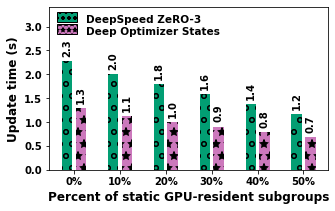

In [35]:
###############################################################
# Plot for update throughput of different twinflow ratios
###############################################################
def plot_diff_twinflow_update_thru(m, config, data):
    output_file = f"./plots/diff-twinflow-update-thru"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.3
    bar_gap = -0.075
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    # ax2 = ax.twinx()
    offset_start = -0.5
    offset = offset_start
    update_thru = {}
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        update_thru[blabel] = [0]*len(group_labels)
        for j, glabel in enumerate(group_labels):
            if data[glabel][blabel]['step'] is not None and len(data[glabel][blabel]['step'])>0:
                # update_thru[blabel][j] = (glabel)/(get_avg(data[glabel][blabel]['step'])/1e3)
                update_thru[blabel][j] = get_avg(data[glabel][blabel]['step'])/1e3
        label = "Default" if blabel == 0 else (str(100//blabel) + "%" + f"[k={blabel}]")
        ax.bar(xrange + offset * bar_width, update_thru[blabel], bar_width+bar_gap, 
               label=f'{label}', color=colors[i], hatch=hatches[i])
        offset += 1
    
    max_y = 0
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = offset_start
        for i, blabel in enumerate(bar_labels):
            value = update_thru[blabel][j]
            max_y = max(max_y, value)
            print_val = f'{value:.1f}'
            print_color = 'black'
            ax.annotate(print_val, (xrange[j] + offset * bar_width, value + 0.1), 
                        ha='center', va='bottom', rotation=90, 
                        fontsize=10, fontweight='bold', zorder=100, color=print_color)
            offset += 1
    
    # ax.set_xlabel('Gradient acc. degree [Global batch size]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Update time (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=max_y*1.5)
    ax.set_xlabel('Percent of static GPU-resident subgroups', fontsize=12, fontweight='bold')
    ax.set_xticklabels([f"{int(100-100*x)}%" for i, x in enumerate(group_labels)])
    # Plot the TFLOPs on secondary y-axis
    # tflops = {}
    # for i, blabel in enumerate(bar_labels):
    #     tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
    #     ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
    #              markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    # ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    # ax2.spines['right'].set_color('blue')
    # ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    # ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    legends = ax.legend(handles, ["DeepSpeed ZeRO-3", "Deep Optimizer States"], 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
m = list(filter(lambda x: x.get('m') == 20, models))[0]
for tfr in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]:
    config = copy.deepcopy(base_config)
    res[tfr] = {}
    for k in [0, 2]:
        res[tfr][k] = None
        config['basepath'] = f"./act-output-{m['m']}B-scale-twinflow/"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['tf_ratio'] = tfr
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        if k==0:
            config['approach'] = DEFAULT_DEEPSPEED
            ans = parse_log(m, config)
            # config['approach'] = PARTLY_OPTIMIZED
            # df_partly = parse_log(m, config)
        else:
            config['approach'] = FULLY_OPTIMIZED
            ans = parse_log(m, config)
        # print(f"Got ans {model}, {k}, {ans}")
        res[tfr][k] = ans

plot_diff_twinflow_update_thru(m, config, res)

Reading ./act-output-20B-scale-gaps-h100/log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-prefetch0-flush_async0-opt_gaps0.log
Reading ./act-output-20B-scale-gaps-h100/log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-prefetch1-flush_async1-opt_gaps2.log
Reading ./act-output-20B-scale-gaps-h100/log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-prefetch1-flush_async1-opt_gaps3.log
Reading ./act-output-20B-scale-gaps-h100/log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-prefetch1-flush_async1-opt_gaps4.log
1.7131252079895145e+18 1.713125210260723e+18 [0.31019358751250475, 0, 0, 0]
1.7131253982634135e+18 1.7131253995678725e+18 [0.31019358751250475, 19.368278681674852, 0, 0]
1.7131255115083656e+18 1.7131255128674337e+18 [0.31019358751250475, 19.368278681674852, 11.947724280533967, 0]
1.713125633113192e+18 1.7131256345013514e+18 [0.31019358751250475, 19.368278681674852, 11.947724280533967, 8.995485975722636]
1.7131252

/tmp/ipykernel_3601/708083416.py:79: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


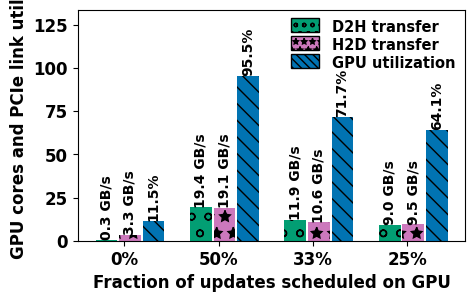

In [213]:
###############################################################
# Plot the avg GPU and PCI utilization for the 20B model
###############################################################

def parse_monitor_file(m, config, start_time, end_time):
    monitor_filename = get_filename(m, config)
    monitor_filename = monitor_filename[:-4] + "-monitor.csv"
    df = pd.read_csv(monitor_filename, header=0)
    df['timestamp'] = df['timestamp'].astype('int64')
    filtered_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]
    # time_units_elapsed = (end_time-start_time)/1e3 # Convert from ns to milliseconds
    # time_units_elapsed /= 20                       # PCIe recordings are taken every 20ms
    filtered_df.loc[:,'txpci'] = filtered_df['txpci']/(1024)  # Convert to GB/s
    filtered_df.loc[:,'rxpci'] = filtered_df['rxpci']/(1024)  # Convert to GB/s
#     filtered_df.loc[:,'gpu_util'] = filtered_df['gpu_util']/time_units_elapsed
    return filtered_df[['txpci', 'rxpci', 'gpu_util', 'mem_util']].mean()
#     return (ans['txpci'], ans['rxpci'], ans['gpu_util'])
    

def plot_diff_k_gpu_pcie_util(m, config, data):
    output_file = f"./plots/diff-diff-k-gpu-pcie-util"
        
    group_labels = list(data.keys())
    bar_labels = ["txpci", "rxpci", "gpu_util"]
    bar_width = 0.25
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
    
    offset_start = -0.75
    offset = offset_start
    util_stats = {}
    select_iter = -2
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        util_stats[blabel] = [0]*len(group_labels)
        for j, glabel in enumerate(group_labels):
            c = copy.deepcopy(config)
            c["opt_gaps"] = glabel
            c["approach"] = FULLY_OPTIMIZED
            if glabel == 0:        # Correpsonds to default approach
                c["approach"] = DEFAULT_DEEPSPEED
            
            start_time = data[glabel].iloc[select_iter]["step_start"]
            end_time = data[glabel].iloc[select_iter]["step_end"]
            util_stats[blabel][j] = parse_monitor_file(m, c, start_time, end_time)[blabel]
            print(start_time, end_time, util_stats[blabel])
        label = blabel
        ax.bar(xrange + offset * bar_width, util_stats[blabel], bar_width+bar_gap, 
               label=f'{label}', color=colors[i], hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        offset = offset_start
        for i, blabel in enumerate(bar_labels):
            value = util_stats[blabel][j]
            max_y = max(max_y, value)
            unit = "%"
            if blabel != "gpu_util":
                unit = " GB/s"
            ax.annotate(f'{value:.1f}{unit}', (xrange[j] + offset * bar_width, value + 0.0), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_ylabel('GPU and PCIe utilization', fontsize=12, fontweight='bold')
    ax.set_xlabel('Fraction of updates scheduled on GPU', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x if x==0 else int(100/x)}%" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.4)

    handles, labels = ax.get_legend_handles_labels()
    labels = ["D2H transfer", "H2D transfer", "GPU utilization"]
    legends = ax.legend(handles, labels, 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper right',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
m = list(filter(lambda x: x.get('m') == 20, models))[0]
for k in [0, 2, 3, 4]:
    config = copy.deepcopy(base_config)
    res[k] = {}
    
    config['basepath'] = f"./act-output-{m['m']}B-scale-gaps-h100"
    config['opt_gaps'] = k
    config['dp'] = 4
    config['mbs'] = 1
    config['tp'] = 1
    config['gbs'] = config['mbs']*config['dp']
    # print("Got config as ", config)
    ans = None
    if k==0:
        config['approach'] = DEFAULT_DEEPSPEED
        ans = parse_log(m, config)
    else:
        config['approach'] = FULLY_OPTIMIZED
        ans = parse_log(m, config)
    res[k] = ans

plot_diff_k_gpu_pcie_util(m, config, res)

/tmp/ipykernel_3601/2092477611.py:64: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


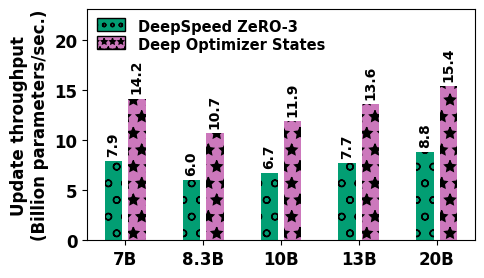

In [111]:
###############################################################
# Plot for different model sizes the update throughput.
###############################################################
def plot_diff_models_update_thru(m, config, data):
    output_file = f"./plots/diff-models-update-thru"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.3
    bar_gap = -0.075
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    # ax2 = ax.twinx()
    offset_start = -0.5
    offset = offset_start
    update_thru = {}
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        update_thru[blabel] = [0]*len(group_labels)
        for j, glabel in enumerate(group_labels):
            if data[glabel][blabel]['step'] is not None and len(data[glabel][blabel]['step'])>0:
                update_thru[blabel][j] = (glabel)/(get_avg(data[glabel][blabel]['step'])/1e3)
                # update_thru[blabel][j] = get_avg(data[glabel][blabel]['step'])/1e3
        label = "Default" if blabel == 0 else (str(100//blabel) + "%" + f"[k={blabel}]")
        ax.bar(xrange + offset * bar_width, update_thru[blabel], bar_width+bar_gap, 
               label=f'{label}', color=colors[i], hatch=hatches[i])
        offset += 1
    
    max_y = 0
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = offset_start
        for i, blabel in enumerate(bar_labels):
            value = update_thru[blabel][j]
            max_y = max(max_y, value)
            print_val = f'{value:.1f}'
            print_color = 'black'
            ax.annotate(print_val, (xrange[j] + offset * bar_width, value + 0.5), 
                        ha='center', va='bottom', rotation=90, 
                        fontsize=10, fontweight='bold', zorder=100, color=print_color)
            offset += 1
    
    # ax.set_xlabel('Gradient acc. degree [Global batch size]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Update throughput\n(Billion parameters/sec.)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x}B" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.5)
    # Plot the TFLOPs on secondary y-axis
    # tflops = {}
    # for i, blabel in enumerate(bar_labels):
    #     tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
    #     ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
    #              markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    # ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    # ax2.spines['right'].set_color('blue')
    # ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    # ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    legends = ax.legend(handles, ["DeepSpeed ZeRO-3", "Deep Optimizer States"], 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
for model in [7, 8.3, 10, 13, 20]:
    m = list(filter(lambda x: x.get('m') == model, models))[0]
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 2]:
        res[model][k] = None
        config['basepath'] = f"./act-output-no-twinflow-all/act-output-{m['m']}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        if k==0:
            config['approach'] = DEFAULT_DEEPSPEED
            ans = parse_log(m, config)
            # config['approach'] = PARTLY_OPTIMIZED
            # df_partly = parse_log(m, config)
        else:
            config['approach'] = FULLY_OPTIMIZED
            ans = parse_log(m, config)
        # print(f"Got ans {model}, {k}, {ans}")
        res[model][k] = ans

plot_diff_models_update_thru(m, config, res)

/tmp/ipykernel_3601/1106826932.py:77: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


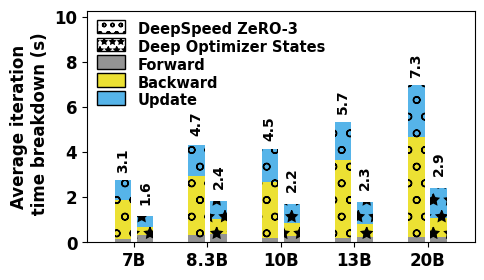

In [117]:
###############################################################
# Plot for different model sizes the breakdown of the iteration time.
###############################################################
def plot_diff_models_iter_time(m, config, data):
    output_file = f"./plots/diff-models-iter-time"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.3
    bar_gap = -0.075
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
#     ax2 = ax.twinx()
    offset = -0.5
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
    
    # Add the legend for hatches first
    for i, blabel in enumerate(bar_labels):
        label = DEFAULT_DEEPSPEED
        if blabel == 2:
            label = FULLY_OPTIMIZED
        ax.bar(xrange, np.zeros(len(xrange)), label=label, hatch=hatches[i], color='white')
    
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        iter_time[blabel] = [get_avg(data[glabel][blabel]['iter_time']) for glabel in group_labels]
        fwd_time[blabel] = [get_avg(data[glabel][blabel]['fwd'])/1e3 for glabel in group_labels]
        bwd_time[blabel] = [get_avg(data[glabel][blabel]['bwd'])/1e3 for glabel in group_labels]
        step_time[blabel] = [get_avg(data[glabel][blabel]['step'])/1e3 for glabel in group_labels]
        
        bottom = np.zeros(len(fwd_time[blabel]))
        ax.bar(xrange + offset * bar_width, fwd_time[blabel], bar_width+bar_gap, 
               label=f'Forward', bottom=bottom, color=FWD_TIME_COLOR, hatch=hatches[i])
        bottom += fwd_time[blabel]
        ax.bar(xrange + offset * bar_width, bwd_time[blabel], bar_width+bar_gap, 
               label=f'Backward', bottom=bottom, color=BWD_TIME_COLOR, hatch=hatches[i])
        bottom += bwd_time[blabel]
        ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, 
               label=f'Update', bottom=bottom, color=STEP_TIME_COLOR, hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        offset = -0.5
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            max_y = max(max_y, value)
            ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 0.0), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_ylabel('Average iteration\n time breakdown (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x}B" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.4)
    # Plot the TFLOPs on secondary y-axis
#     tflops = {}
#     for i, blabel in enumerate(bar_labels):
#         tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
#         ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
#                  markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
#     ax2.tick_params(axis='y', color='blue', labelcolor='blue')
#     ax2.spines['right'].set_color('blue')
#     ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
#     ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3]
    legends = ax.legend(handles, labels, 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
for model in [7, 8.3, 10, 13, 20]:
    m = list(filter(lambda x: x.get('m') == model, models))[0]
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 2]:
        res[model][k] = None
        config['basepath'] = f"./act-output-no-twinflow-all/act-output-{m['m']}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        if k==0:
            config['approach'] = DEFAULT_DEEPSPEED
            ans = parse_log(m, config)
            # config['approach'] = PARTLY_OPTIMIZED
            # df_partly = parse_log(m, config)
        else:
            config['approach'] = FULLY_OPTIMIZED
            ans = parse_log(m, config)
        res[model][k] = ans

plot_diff_models_iter_time(m, config, res)

/tmp/ipykernel_3601/925690089.py:66: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


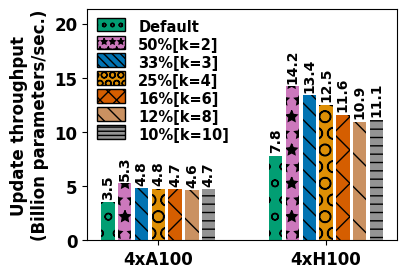

In [72]:
###############################################################
# Plot for different K values for 20B model on H100 and A100
###############################################################
def plot_scale_k_diff_gpus(m, config, data):
    output_file = f"./plots/{m['m']}B-scale-gaps-diff-gpu"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.1
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(4, 3))
    # ax2 = ax.twinx()
    offset_start = -3
    offset = offset_start
    update_thru = {}
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        update_thru[blabel] = [0]*len(group_labels)
        for j, glabel in enumerate(group_labels):
            if data[glabel][blabel]['step'] is not None and len(data[glabel][blabel]['step'])>0:
                update_thru[blabel][j] = (m['m'])/(get_avg(data[glabel][blabel]['step'])/1e3)
                # update_thru[blabel][j] = get_avg(data[glabel][blabel]['step'])
        label = "Default" if blabel == 0 else (str(100//blabel) + "%" + f"[k={blabel}]")
        ax.bar(xrange + offset * bar_width, update_thru[blabel], bar_width+bar_gap, 
               label=f'{label}', color=colors[i], hatch=hatches[i])
        offset += 1
    
    max_y = 0
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = offset_start
        for i, blabel in enumerate(bar_labels):
            value = update_thru[blabel][j]
            max_y = max(max_y, value)
            print_val = f'{value:.1f}'
            print_color = 'black'
            if value == 0:
                print_val = '$\\mathbf{\\times} OOM$'
                print_color = 'red'
            ax.annotate(print_val, (xrange[j] + offset * bar_width, value + 0.3), 
                        ha='center', va='bottom', rotation=90, 
                        fontsize=10, fontweight='bold', zorder=100, color=print_color)
            offset += 1
    
    # ax.set_xlabel('Gradient acc. degree [Global batch size]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Update throughput\n(Billion parameters/sec.)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"4x{x.upper()}" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.5)
    # Plot the TFLOPs on secondary y-axis
    # tflops = {}
    # for i, blabel in enumerate(bar_labels):
    #     tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
    #     ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
    #              markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    # ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    # ax2.spines['right'].set_color('blue')
    # ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    # ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    legends = ax.legend(handles, labels, ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

# Parse log for 7B and/or 13B models for varying GA values
m = list(filter(lambda x: x.get('m') == 7, models))[0]
config = copy.deepcopy(base_config)
res = {}
for gpu in ["a100", "h100"]:
    res[gpu] = {}
    for k in [0, 2, 3, 4, 6, 8, 10]:
        res[gpu][k] = None
        config['basepath'] = f"./act-output-{m['m']}B-scale-gaps-{gpu}"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        if k==0:
            config['approach'] = DEFAULT_DEEPSPEED
            ans = parse_log(m, config)
            # config['approach'] = PARTLY_OPTIMIZED
            # df_partly = parse_log(m, config)
        else:
            config['approach'] = FULLY_OPTIMIZED
            ans = parse_log(m, config)
        # print(f"Got ans {dp}, {k}, {ans}")
        res[gpu][k] = ans

plot_scale_k_diff_gpus(m, config, res)



In [14]:
###############################################################
# Plot update throughput for increasing k and DP
###############################################################
def plot_scale_k_scale_DP(m, config, data):
    output_file = f"./plots/{m['m']}B-scale-k-scale-DP"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.1
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    # ax2 = ax.twinx()
    offset_start = -3
    offset = offset_start
    update_thru = {}
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        update_thru[blabel] = [0]*len(group_labels)
        for j, glabel in enumerate(group_labels):
            if data[glabel][blabel]['step'] is not None and len(data[glabel][blabel]['step'])>0:
                update_thru[blabel][j] = (m['m'])/(get_avg(data[glabel][blabel]['step'])/1e3)
        label = "Default" if blabel == 0 else (str(100//blabel) + "%")
        ax.bar(xrange + offset * bar_width, update_thru[blabel], bar_width+bar_gap, 
               label=f'{label}', color=colors[i], hatch=hatches[i])
        offset += 1
    
    max_y = 0
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = offset_start
        for i, blabel in enumerate(bar_labels):
            value = update_thru[blabel][j]
            max_y = max(max_y, value)
            print_val = f'{value:.1f}'
            print_color = 'black'
            if value == 0:
                print_val = '$\\mathbf{\\times} OOM$'
                print_color = 'red'
            ax.annotate(print_val, (xrange[j] + offset * bar_width, value + 0.3), 
                        ha='center', va='bottom', rotation=90, 
                        fontsize=10, fontweight='bold', zorder=100, color=print_color)
            offset += 1
    
    # ax.set_xlabel('Gradient acc. degree [Global batch size]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Update throughput\n(Billion parameters/sec.)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    if m['m'] == 30:
        ax.set_xticklabels([f"DP={x},TP={8//x}" for i, x in enumerate(group_labels)])
    else:
        ax.set_xticklabels([f"DP={x},TP=1" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.5)
    # Plot the TFLOPs on secondary y-axis
    # tflops = {}
    # for i, blabel in enumerate(bar_labels):
    #     tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
    #     ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
    #              markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    # ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    # ax2.spines['right'].set_color('blue')
    # ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    # ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    legends = ax.legend(handles, labels, ncol=4, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

# Parse log for 7B and/or 13B models for varying GA values
m = list(filter(lambda x: x.get('m') == 13, models))[0]
config = copy.deepcopy(base_config)
res = {}
for dp in [1, 2, 4]:
    if m['m'] == 30:
        dp *= 2
    res[dp] = {}
    for k in [0, 2, 3, 4, 5, 6, 8, 10]:
        res[dp][k] = None
        config['basepath'] = f"./act-output-{m['m']}B-scale-gaps-scale-DP"
        config['opt_gaps'] = k
        config['dp'] = dp
        config['tp'] = 1 if m['m'] != 30 else (8//dp)
        config['gbs'] = config['mbs']*dp
        # print("Got config as ", config)
        ans = None
        if k==0:
            config['approach'] = DEFAULT_DEEPSPEED
            ans = parse_log(m, config)
            # config['approach'] = PARTLY_OPTIMIZED
            # df_partly = parse_log(m, config)
        else:
            config['approach'] = FULLY_OPTIMIZED
            ans = parse_log(m, config)
        # print(f"Got ans {dp}, {k}, {ans}")
        res[dp][k] = ans

plot_scale_k_scale_DP(m, config, res)

FileNotFoundError: [Errno 2] No such file or directory: './act-output-13B-scale-gaps-scale-DP/log-13B-tp1-dp1-l40-h5120-a40-sl2048-gbs1-mbs1-ratio1-subg100000000-prefetch0-flush_async0-opt_gaps0.log'

[0 1 2 3 4]


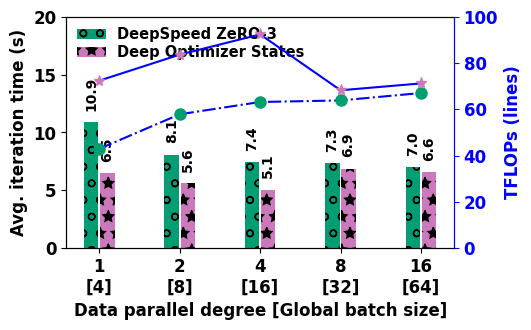

In [8]:
###############################################################
# Plot for increasing DP
###############################################################

def plot_scale_DP(m, config, data):
    output_file = f"./plots/{m['m']}B-scale-DP"

    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.2
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()
    print(xrange)
    offset = -0.5
    iter_time = {}
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        iter_time[blabel] = [get_avg(data[glabel][blabel]['elapsed_time_per_iteration_ms'])/1e3 for glabel in group_labels]
        ax.bar(xrange + offset * bar_width, iter_time[blabel], bar_width+bar_gap, label=f'Bar {blabel}', color=colors[i], hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = -0.5
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 1), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_xlabel('Data parallel degree [Global batch size]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Avg. iteration time (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=40)
    if m['m'] == 7:
        ax.set_ylim(top=20)
    ax.set_xticklabels([f"{x}\n[{x*config['mbs']}]" for i, x in enumerate(group_labels)])
    
    # Plot the TFLOPs on secondary y-axis
    tflops = {}
    for i, blabel in enumerate(bar_labels):
        tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
        ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
                 markersize=8, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    ax2.spines['right'].set_color('blue')
    ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    ax2.set_ylim(bottom=0, top=100)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, bar_labels, ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.2, ) 
    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

# Parse log for 7B and/or 13B models for varying DP values
m = list(filter(lambda x: x.get('m') == 7, models))[0]
config = copy.deepcopy(base_config)
res_scale_dp = {}
for dp in [1, 2, 4, 8, 16]:
    config['basepath'] = f"./act-output-{m['m']}B-scale-DP"
    config['dp'] = dp
    config['gbs'] = config['mbs']*dp
    config['approach'] = DEFAULT_DEEPSPEED
    df_default = parse_log(m, config)
    config['approach'] = PARTLY_OPTIMIZED
    df_partly = parse_log(m, config)
    config['approach'] = FULLY_OPTIMIZED
    df_fully = parse_log(m, config)
    res_scale_dp[dp] = {DEFAULT_DEEPSPEED: df_default, 
#                         PARTLY_OPTIMIZED: df_partly, 
                        FULLY_OPTIMIZED: df_fully}

plot_scale_DP(m, config, res_scale_dp)

/tmp/ipykernel_12516/2559112903.py:75: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


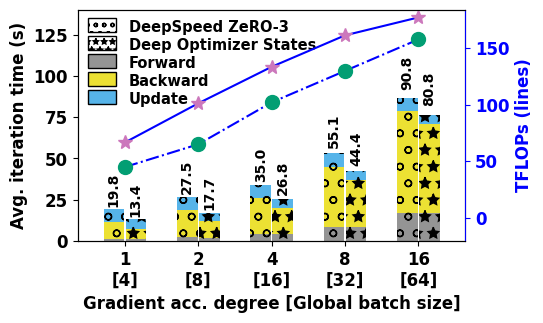

In [98]:

###############################################################
# Plot for increasing GA
###############################################################
def plot_scale_GA(m, config, data):
    output_file = f"./plots/{m['m']}B-scale-GA"

    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.3
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()
    offset = -0.5
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
    
    # Add the legend for hatches first
    for i, blabel in enumerate(bar_labels):
        ax.bar(xrange, np.zeros(len(xrange)), label=blabel, hatch=hatches[i], color='white')
    
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        iter_time[blabel] = [get_avg(data[glabel][blabel]['iter_time']) for glabel in group_labels]
        fwd_time[blabel] = [get_avg(data[glabel][blabel]['fwd'])/1e3 for glabel in group_labels]
        bwd_time[blabel] = [get_avg(data[glabel][blabel]['bwd'])/1e3 for glabel in group_labels]
        step_time[blabel] = [get_avg(data[glabel][blabel]['step'])/1e3 for glabel in group_labels]
        
        bottom = np.zeros(len(fwd_time[blabel]))
        ax.bar(xrange + offset * bar_width, fwd_time[blabel], bar_width+bar_gap, 
               label=f'Forward', bottom=bottom, color=FWD_TIME_COLOR, hatch=hatches[i])
        bottom += fwd_time[blabel]
        ax.bar(xrange + offset * bar_width, bwd_time[blabel], bar_width+bar_gap, 
               label=f'Backward', bottom=bottom, color=BWD_TIME_COLOR, hatch=hatches[i])
        bottom += bwd_time[blabel]
        ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, 
               label=f'Update', bottom=bottom, color=STEP_TIME_COLOR, hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = -0.5
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 1), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_xlabel('Gradient acc. degree [Global batch size]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Avg. iteration time (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=140)
    if m['m'] == 7:
        ax.set_ylim(top=75)
    ax.set_xticklabels([f"{x}\n[{x*config['mbs']}]" for i, x in enumerate(group_labels)])
    
    # Plot the TFLOPs on secondary y-axis
    tflops = {}
    for i, blabel in enumerate(bar_labels):
        tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
        ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
                 markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    ax2.spines['right'].set_color('blue')
    ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3] # Legend for only number of approches + 3 (fwd, bwd, update)
    legends = ax.legend(handles, labels, ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.2, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

# Parse log for 7B and/or 13B models for varying GA values
m = list(filter(lambda x: x.get('m') == 13, models))[0]
config = copy.deepcopy(base_config)
res_scale_ga = {}
for ga in [1, 2, 4, 8, 16]:
    config['basepath'] = f"./act-output-{m['m']}B-scale-GA-single-GPU"
    config['ga'] = ga
    config['gbs'] = config['mbs']*ga
    config['approach'] = DEFAULT_DEEPSPEED
    df_default = parse_log(m, config)
    config['approach'] = PARTLY_OPTIMIZED
    df_partly = parse_log(m, config)
    config['approach'] = FULLY_OPTIMIZED
    df_fully = parse_log(m, config)
    res_scale_ga[ga] = {DEFAULT_DEEPSPEED: df_default, 
#                         PARTLY_OPTIMIZED: df_partly, 
                        FULLY_OPTIMIZED: df_fully}

plot_scale_GA(m, config, res_scale_ga)


/tmp/ipykernel_22317/2657972364.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


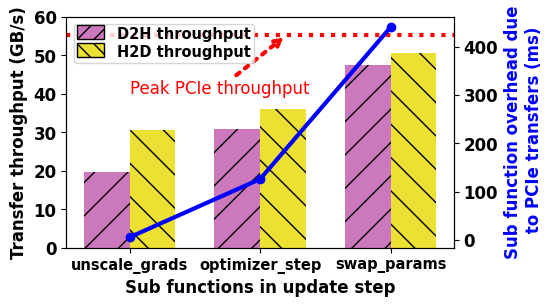

In [94]:
##### This graph is for flexscience paper

import matplotlib.pyplot as plt
import seaborn as sns

def plot_throughput_overhead(data):
    # Set seaborn style and color palette
    sns.set_palette("colorblind")

    # Extract data
    functions = data['Function']
    d2h_throughput = data['D2H throughput']
    h2d_throughput = data['H2D throughput']
    overhead = data['Overhead on func']

    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot grouped bars for D2H and H2D throughput
    width = 0.35
    x = range(len(functions))
    ax1.bar([i-width/2 for i in x], d2h_throughput, width, color=colors[1], hatch="/", label='D2H throughput')
    ax1.bar([i+width/2 for i in x], h2d_throughput, width, color=colors[7], hatch="\\", label='H2D throughput')

    # Plot line for Overhead on func on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(x, overhead, color='blue', linestyle='-', marker='o', lw=3, label='Overhead')

    # Set x-ticks and labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(functions, rotation=0, fontsize=10.5, fontweight='bold')
    ax1.set_xlabel('Sub functions in update step', fontsize=12, fontweight='bold')

    # Set y-axis labels
    ax1.set_ylabel('Transfer throughput (GB/s)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Sub function overhead due\n to PCIe transfers (ms)', fontsize=12, fontweight='bold', color='blue')

    # Set plot title and legend
    handles, labels = ax1.get_legend_handles_labels()
    labels = ["D2H throughput", "H2D throughput"]
    legends = ax1.legend(handles, labels, ncol=1, frameon=True, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.2, ) 
    
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        handle.set_hatch(handle.get_hatch()*2)
    ax1.axhline(y=55.2, color='r', lw=3, linestyle=':', label='Peak PCIe throughput')
    ax1.annotate("Peak PCIe throughput", xy=(1.2, 55.2), xytext=(0.0, 40), 
                 color='r', fontweight='normal',
                 arrowprops=dict(arrowstyle="->", ls=":", lw=3, color='r'))
    # ax1.text(1.2, 40, 'Peak PCIe throughput', color='r', ha='right')
    # ax1.arrow(1.2, 40, 0.2, 15.2)
    ax1.set_ylim(top=60)

    plt.savefig(f"flexscience-breakdown.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"flexscience-breakdown.png", format='png', bbox_inches='tight')
    # Show plot
    plt.show()

# Sample data
data = {
    'Function': ['unscale_grads', 'optimizer_step', 'swap_params'],
    'D2H throughput': [19.668462, 30.83922, 47.37459],
    'H2D throughput': [30.59208, 35.95705, 50.678],
    'Overhead on func': [5.25, 126, 441]
}

# Call the function with sample data
plot_throughput_overhead(data)
